<a href="https://colab.research.google.com/github/kmayutrisna/SA_IMDB/blob/main/3_IMDB_glove_CNN_Base_USE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#DATA PREPARATION
# Importing essential libraries and functions
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Get the dataset from gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Display top of data
data =pd.read_csv("drive/My Drive/data/IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# Convert sentiment to binary labels
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})
data = data.sample(frac=1).reset_index(drop=True)  # Shuffling the dataset
X = data['review'].values
y = data['sentiment'].values

In [5]:
# Splitting the dataset into training, validation, and testing sets
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
test_size = len(X) - train_size - val_size

In [6]:
X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]
X_test = X[-test_size:]
y_test = y[-test_size:]

In [7]:
# Tokenizing the texts
vocab_size = 10000  # Maximum number of words to keep in the vocabulary
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

In [8]:
# Converting text sequences to integer sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [9]:
# Padding sequences
max_length = 100  # Maximum sequence length
train_data = pad_sequences(train_sequences, maxlen=max_length)
val_data = pad_sequences(val_sequences, maxlen=max_length)
test_data = pad_sequences(test_sequences, maxlen=max_length)

In [10]:
# Loading the GloVe word embeddings
glove_path = 'drive/My Drive/data/glove.6B.100d.txt'

In [11]:
embedding_dim = 100  # Dimensionality of the word embeddings
embedding_index = {}
with open(glove_path, 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefficients

In [12]:
# Creating an embedding matrix
word_index = tokenizer.word_index
num_words = min(vocab_size, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [13]:
# Creating the CNN model1
model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [13]:
# Build the CNN model2
model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [14]:
# Compiling and training the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
# Train model
history = model.fit(train_data, y_train, epochs=10, batch_size=32, validation_data=(val_data, y_val))

Epoch 1/10
1250/1250 [==============================] - 23s 18ms/step - loss: 0.4982 - accuracy: 0.7504 - val_loss: 0.4104 - val_accuracy: 0.8086
Epoch 2/10
1250/1250 [==============================] - 21s 17ms/step - loss: 0.3746 - accuracy: 0.8312 - val_loss: 0.3830 - val_accuracy: 0.8204
Epoch 3/10
1250/1250 [==============================] - 21s 17ms/step - loss: 0.3208 - accuracy: 0.8595 - val_loss: 0.3881 - val_accuracy: 0.8230
Epoch 4/10
1250/1250 [==============================] - 22s 17ms/step - loss: 0.2679 - accuracy: 0.8867 - val_loss: 0.4121 - val_accuracy: 0.8198
Epoch 5/10
1250/1250 [==============================] - 22s 17ms/step - loss: 0.2122 - accuracy: 0.9145 - val_loss: 0.4353 - val_accuracy: 0.8174
Epoch 6/10
1250/1250 [==============================] - 22s 17ms/step - loss: 0.1570 - accuracy: 0.9396 - val_loss: 0.4592 - val_accuracy: 0.8164
Epoch 7/10
1250/1250 [==============================] - 22s 18ms/step - loss: 0.1126 - accuracy: 0.9607 - val_loss: 0.5197 -

In [16]:
# Evaluating the model
y_pred = model.predict(test_data)
y_pred_binary = np.round(y_pred).flatten()

157/157 [==============================] - 1s 6ms/step


In [17]:
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8094
Precision: 0.8206951026856241
Recall: 0.8063639891346527
F1-score: 0.8134664317870425


In [18]:
# Plot model performance

def plot_model_performance(history):
    # Accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

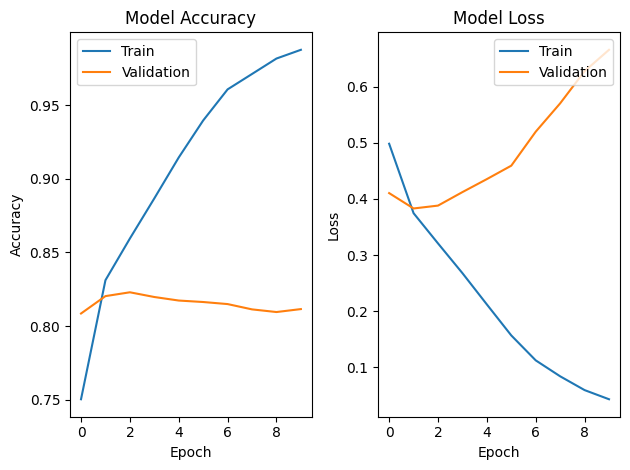

In [19]:
# Plot the model performance
plot_model_performance(history)

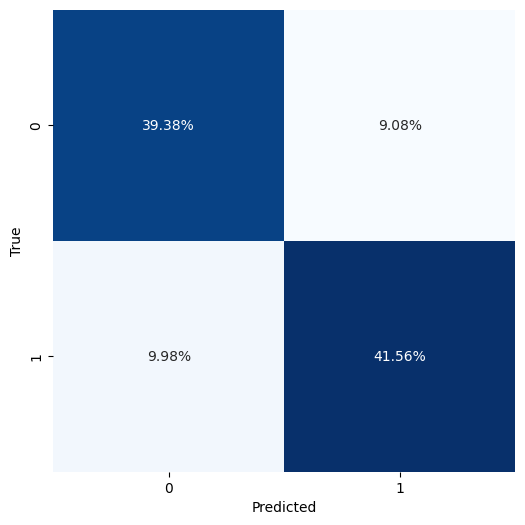

In [20]:
# Calculate the confusion matrix

cm = confusion_matrix(y_test, y_pred_binary)
# Normalize the confusion matrix to display percentages out of the total
cm_norm = cm.astype('float') / cm.sum()

plt.figure(figsize=(6, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()